# Fit CdSe Nanoparticle PDF

This is an example of using the DiffPy-CMI framework to fit a X-ray PDF of
CdSe Nanoparticles.  It shows how to build a simple fit recipe using a PDF
data file and fit it using a non-periodic nanoparticle structure model.

To adapt this example to fit your own data, replace the ``dataFile`` and
``structureFile``.  You may need modify some variable names and the ADP to fit
your own structure model.


In [25]:
from __future__ import print_function

# We'll need numpy and matplotlib for plotting our results
import numpy as np
import matplotlib.pyplot as plt

# A least squares fitting algorithm from scipy
from scipy.optimize.minpack import leastsq

# DiffPy-CMI modules for building a fitting recipe
from diffpy.Structure import loadStructure
from diffpy.srfit.pdf import PDFContribution
from diffpy.srfit.fitbase import FitRecipe, FitResults

%matplotlib notebook

 Files containing our experimental data and structure file


In [2]:
dataFile = "cdse.gr"
structureFile = "cdse.xyz"

 The first thing to construct is a contribution. Since this is a simple example, the contribution will simply contain our PDF data and an associated structure file. We'll give it the  name "cdse".

In [3]:
cdsePDF = PDFContribution("CdSe")

Load the data and set the r-range over which we'll fit.


In [4]:
cdsePDF.loadData(dataFile)
cdsePDF.setCalculationRange(xmin=1, xmax=20, dx=0.01)

Add the structure from our xyz file to the contribution, since the structure model is non-periodic, we need to specify the periodic=False here to get the right PDF.

In [5]:
cdseStructure = loadStructure(structureFile)
cdsePDF.addStructure("CdSe", cdseStructure, periodic=False);

The FitRecipe does the work of managing one or more contributions that are optimized together.  In addition, FitRecipe configures fit variables that are tied to the model parameters and thus controls the calculated profiles.


In [6]:
cdseFit = FitRecipe()

Give the PDFContribution to the FitRecipe


In [7]:
cdseFit.addContribution(cdsePDF)

Here we create variables for the overall scale of the PDF and a delta2 parameter for correlated motion of neighboring atoms.

In [8]:
cdseFit.addVar(cdsePDF.scale, 1)
cdseFit.addVar(cdsePDF.CdSe.delta2, 5)


We fix Qdamp based on prior information about our beamline.

In [9]:
cdseFit.addVar(cdsePDF.qdamp, 0.06, fixed=True)

 Since we are calculating PDF from a non-periodic structure, we also need to specify the Qmin to get he correct PDF. The value of Qmin could be the actual Qmin in the experiment or the Qmin used in PDF transformation, or some value related to the size and the shape of the structure model. 
 
 Usually a value in (0.5 ~ 1.0) will give reasonable  results.


In [10]:
cdsePDF.CdSe.setQmin(1.0)

The Qmax used in PDF transformation should also be specfied


In [11]:
cdsePDF.CdSe.setQmax(20.0)

 We create the variables of ADP and assign the initial value to them. In this example, we use isotropic ADP for all atoms

In [12]:
CdBiso = cdseFit.newVar("Cd_Biso", value=1.0)
SeBiso = cdseFit.newVar("Se_Biso", value=1.0)

For all atoms in the structure model, we constrain their Biso according to their species.

In [13]:
atoms = cdsePDF.CdSe.phase.getScatterers()
for atom in atoms:
    if atom.element == 'Cd':
        cdseFit.constrain(atom.Biso, CdBiso)
    elif atom.element == 'Se':
        cdseFit.constrain(atom.Biso, SeBiso)

Now we create a zoomscale factor which stretches the structure model, this is useful when you want to fit the bond length. Note that the relative position of atoms are not changed during the refinements.

In [14]:
zoomscale = cdseFit.newVar('zoomscale', value=1.0)

Here is a simple we to assign the zoomscale to the structure. Note that this only works for NON-PERIODIC structure

In [15]:
lattice = cdsePDF.CdSe.phase.getLattice()
cdseFit.constrain(lattice.a, zoomscale)
cdseFit.constrain(lattice.b, zoomscale)
cdseFit.constrain(lattice.c, zoomscale)

 Turn off printout of iteration number.


In [16]:
cdseFit.clearFitHooks()

We can now execute the fit using scipy's least square optimizer.

In [17]:
print("  variables:", cdseFit.names)
print("  initial values:", cdseFit.values)

  variables: ['scale', 'delta2', 'Cd_Biso', 'Se_Biso', 'zoomscale']
  initial values: [1. 5. 1. 1. 1.]


In [18]:
leastsq(cdseFit.residual, cdseFit.values)

(array([0.35245771, 5.32907   , 3.45482665, 1.40414758, 0.99423982]), 1)

In [19]:
print("  variables:", cdseFit.names)
print("  final values:", cdseFit.values)


  variables: ['scale', 'delta2', 'Cd_Biso', 'Se_Biso', 'zoomscale']
  final values: [0.35245771 5.32907    3.45482665 1.40414758 0.99423982]


Obtain and display the fit results.


In [20]:
cdseResults = FitResults(cdseFit)
print("FIT RESULTS\n")
print(cdseResults)

FIT RESULTS

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       0.74288523
Contributions  0.74288523
Restraints     0.00000000
Chi2           0.74288523
Reduced Chi2   0.00039182
Rw             0.11338206

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Cd_Biso    3.45482665e+00 +/- 2.70605073e+00
Se_Biso    1.40414758e+00 +/- 2.79922987e+00
delta2     5.32907000e+00 +/- 9.03482485e-01
scale      3.52457714e-01 +/- 6.73140109e-02
zoomscale  9.94239823e-01 +/- 6.23799868e-03

Fixed Variables
------------------------------------------------------------------------------
qdamp  6.00000000e-02

Variable Correlations greater than 25% (Correlations invalid)
------------------------------------------------------------------------------
corr(Cd_Biso, Se_Biso)   -0.8030
corr(scale, Cd_Biso) 

Plot the observed and refined PDF.  First, gather the experimental data from the recipe.

In [21]:
r = cdseFit.CdSe.profile.x
gobs = cdseFit.CdSe.profile.y

Get the calculated PDF and compute the difference between the calculated and measured PDF

In [22]:
gcalc = cdseFit.CdSe.evaluate()
baseline = 1.1 * gobs.min()
gdiff = gobs - gcalc

Finally, show the plot!

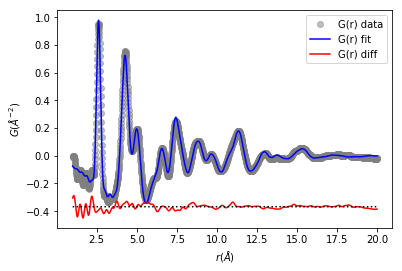

In [24]:
# Plot!
plt.figure()
plt.plot(r, gobs, 'o', color='.5', label="G(r) data",alpha=.5)
plt.plot(r, gcalc, 'b-', label="G(r) fit")
plt.plot(r, gdiff + baseline, 'r-', label="G(r) diff")
plt.plot(r, np.zeros_like(r) + baseline, 'k:')
plt.xlabel(r"$r (\AA)$")
plt.ylabel(r"$G (\AA^{-2})$")
plt.legend()

